In [ ]:
!pip install imbalanced-learn

In [1]:
%matplotlib inline

import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import RandomUnderSampler
from sklearn.manifold import TSNE

import autosklearn.classification
from sklearn.metrics import f1_score
from sklearn.preprocessing import QuantileTransformer

In [61]:
def get_x_y(df):
    return df.drop('isFraud', axis=1).values, df.isFraud.values

In [52]:
def undersample(df):
    # undersample dataset
    rus = RandomUnderSampler(random_state=42)
    X, y = rus.fit_resample(df.drop('isFraud', axis=1).values, df.isFraud.values)

    
    return pd.DataFrame(
        data=np.c_[ X, y ],
        columns=np.append( df.drop('isFraud', axis=1).columns.values, 'isFraud')
    )

In [25]:
def plot_classes(df):
    ax = df.groupby(df['isFraud'])['isFraud'].count().plot(kind='bar')
    x_offset = -0.05
    y_offset = 0
    for p in ax.patches:
        b = p.get_bbox()
        val = "{}".format(int(b.y1 + b.y0))
        ax.annotate(val, ((b.x0 + b.x1)/2 + x_offset, b.y1 + y_offset))

In [2]:
def plot_tsne(x_, y_):
    tsne = TSNE(n_components=2, random_state=0)
    X_2d = tsne.fit_transform(x_)
    plt.figure(figsize=(10,10))
    plt.scatter(X_2d[:,0], X_2d[:,1], color=['r' if y==1 else 'g' for y in y_])
    plt.show()

In [3]:
def plot_correlation(df_):
    corr = df_.corr()

    f, ax = plt.subplots(figsize=(15, 8))
    sns.heatmap(corr, annot=True, fmt="f",
                xticklabels=corr.columns.values,
                yticklabels=corr.columns.values,
                ax=ax)

In [4]:
def plot_money(df):
    plt.figure(figsize=(20,20))
    plt.subplot(10, 1, 1)
    df[(df.type_id == 0)].amount.plot.line(title='Amount NF')

    plt.subplot(10, 1, 2)
    df[(df.type_id == 1)].amount.plot.line(color='r', title='Amount F')

    plt.subplot(10, 1, 3)
    df[(df.type_id == 0)].oldbalanceOrg.plot.line(title='Old Balance Orig NF')
    plt.subplot(10, 1, 4)
    df[(df.type_id == 1)].oldbalanceOrg.plot.line(color='r',title='Old Balance Orig F')

    plt.subplot(10, 1, 5)
    df[(df.type_id == 0)].newbalanceOrig.plot.line(title='New Balance Orig NF')
    plt.subplot(10, 1, 6)
    df[(df.type_id == 1)].newbalanceOrig.plot.line(color='r',title='New Balance Orig F')


    plt.subplot(10, 1, 7)
    df[(df.type_id == 0)].oldbalanceOrg.plot.line(title='Old Balance Orig NF')
    plt.subplot(10, 1, 8)
    df[(df.type_id == 1)].oldbalanceOrg.plot.line(color='r',title='Old Balance Orig FF')

    plt.subplot(10, 1, 9)
    df[(df.type_id == 0)].newbalanceOrig.plot.line(title='New Balance Orig NF')
    plt.subplot(10, 1, 10)
    df[(df.type_id == 1)].newbalanceOrig.plot.line(color='r',title='New Balance Orig F')

    plt.show()

## Get the dataset if needed

In [19]:
if not os.path.exists('data'):
    !mkdir -p data/
    !aws s3 sync s3://spock.cloud.data/datasets/credit-card/Dataset2/ data/
    !cat data/transactions.training.csv > data/transactions.csv
    !grep -v 'isFraud' data/transactions.test.csv  >> data/transactions.csv 

## Load and prepare the dataset

In [20]:
df = pd.read_csv('data/transactions.csv')

In [21]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,1,TRANSFER,181.0,C1305486145,181.0,0.0,C553264065,0.0,0.0,1
1,1,CASH_OUT,181.0,C840083671,181.0,0.0,C38997010,21182.0,0.0,1
2,1,TRANSFER,2806.0,C1420196421,2806.0,0.0,C972765878,0.0,0.0,1
3,1,CASH_OUT,2806.0,C2101527076,2806.0,0.0,C1007251739,26202.0,0.0,1
4,1,TRANSFER,20128.0,C137533655,20128.0,0.0,C1848415041,0.0,0.0,1


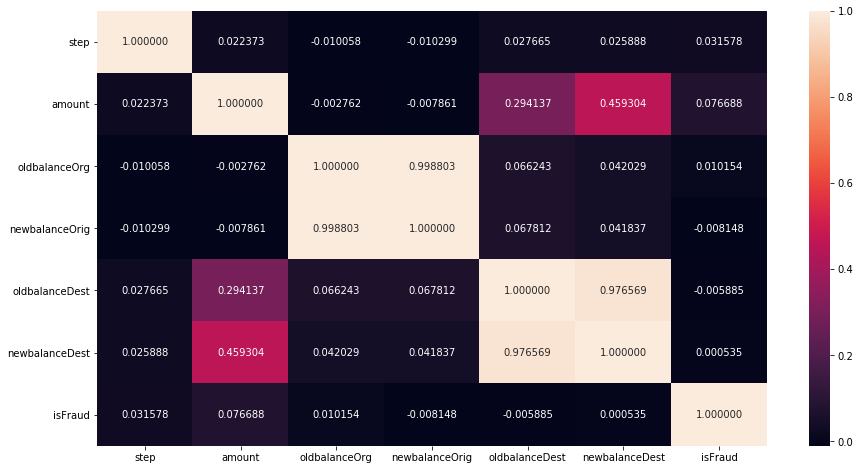

In [22]:
plot_correlation(df)

## Converts type to an enumeration

In [23]:
df['type'] = df['type'].astype('category')
df['type_id'] = df["type"].cat.codes

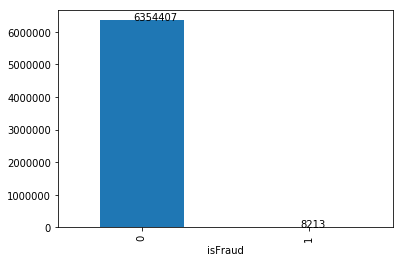

In [26]:
plot_classes(df)

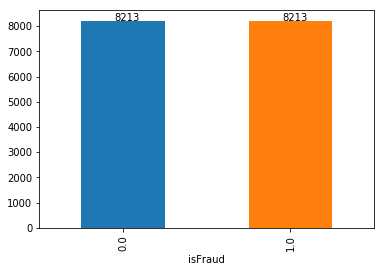

In [53]:
df_ = df.drop(['step', 'type', 'nameOrig', 'nameDest'], axis=1)
df_ = undersample(df_)
plot_classes(df_)

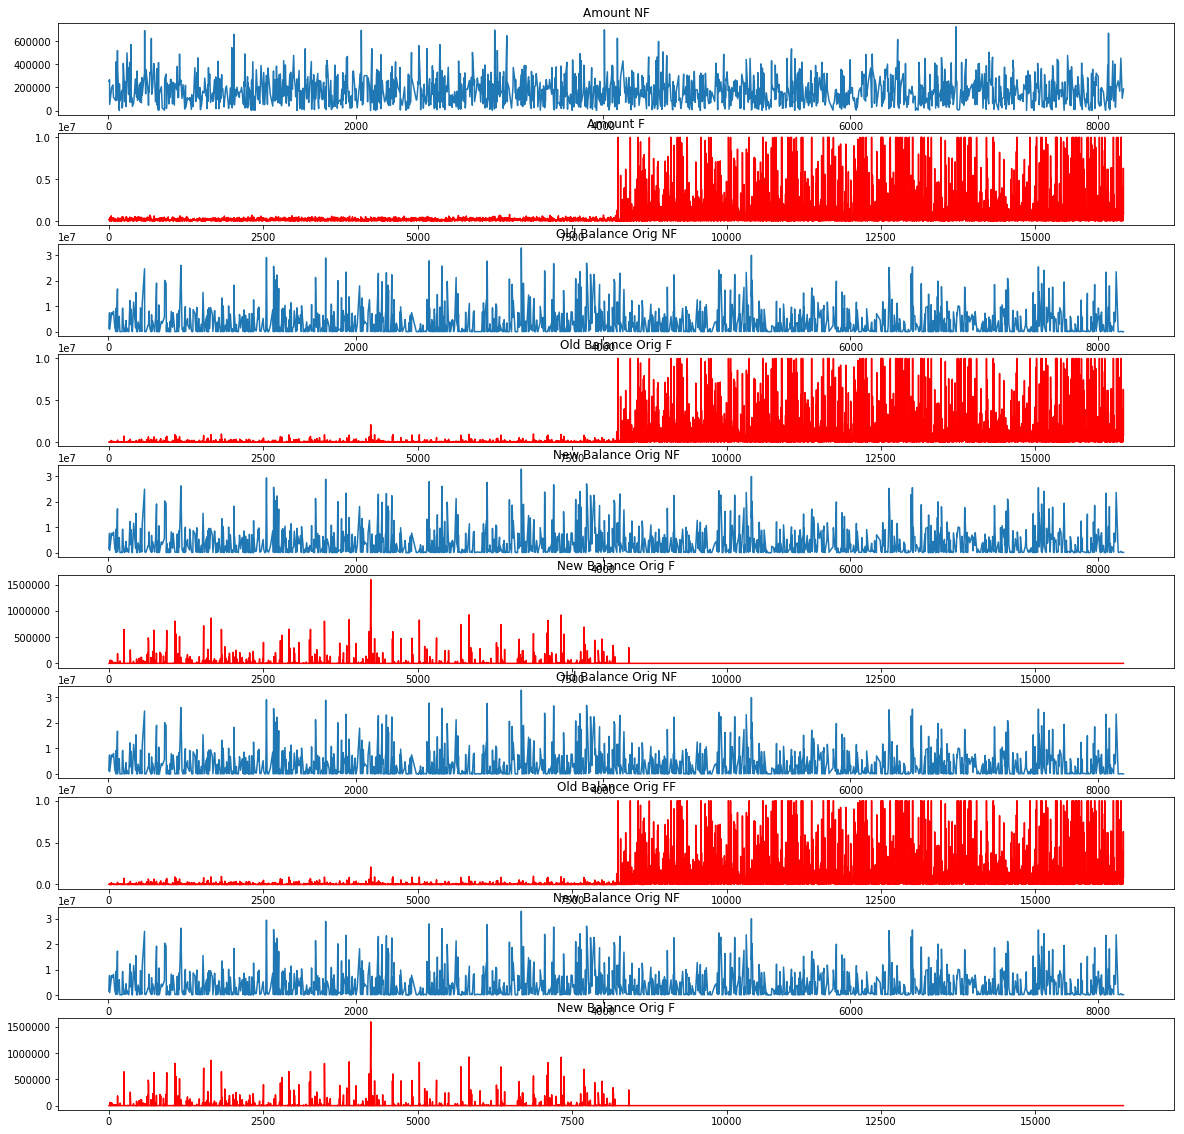

In [54]:
plot_money(df_)

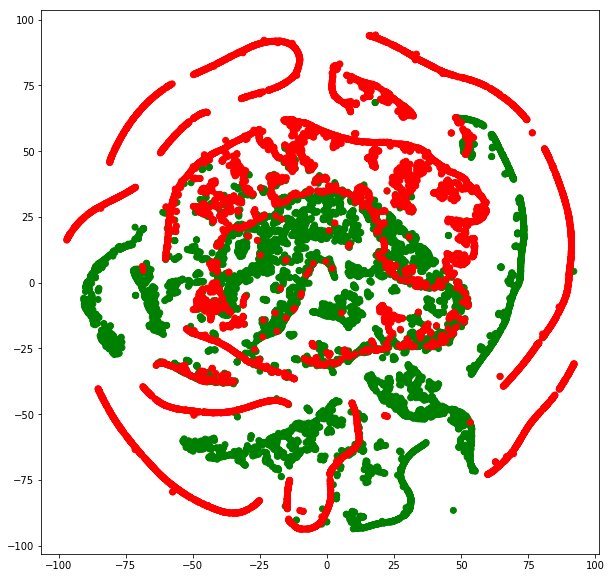

In [62]:
X,y = get_x_y(df_)
plot_tsne(X,y)

...scary...

## ok. now let's compute quantiles for the money

In [66]:
%%time

df__ = df_.copy()
qtf = QuantileTransformer(n_quantiles=10, random_state=0)

qtf.fit([np.sort(df__.amount.values)])
df__.amount = qtf.transform([df__.amount.values])[0]
print('Amount done...')
qtf.fit([np.sort(df__.oldbalanceOrg.values)])
df__.oldbalanceOrg = qtf.transform([df__.oldbalanceOrg.values])[0]
print('OldBalance Origin done...')
qtf.fit([np.sort(df__.newbalanceOrig.values)])
df__.newbalanceOrig = qtf.transform([df__.newbalanceOrig.values])[0]
print('NewBalance Origin done...')
qtf.fit([np.sort(df__.oldbalanceDest.values)])
df__.oldbalanceDest = qtf.transform([df__.oldbalanceDest.values])[0]
print('OldBalance Destine done...')
qtf.fit([np.sort(df__.newbalanceDest.values)])
df__.newbalanceDest = qtf.transform([df__.newbalanceDest.values])[0]
print('NewBalance Destine done...')
df__.type_id = df__.type_id.astype('int')
df__.isFraud = df__.isFraud.astype('int')

Amount done...
OldBalance Origin done...
NewBalance Origin done...
OldBalance Destine done...
NewBalance Destine done...
CPU times: user 48.6 s, sys: 15.1 ms, total: 48.7 s
Wall time: 48.6 s


In [84]:
df__.head()

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,type_id,isFraud
0,1.0,9.999999e-01,1.000000e-07,9.999999e-01,9.999999e-01,1,0
1,1.0,1.000000e-07,1.000000e-07,1.000000e-07,1.000000e-07,3,0
2,1.0,9.999999e-01,9.999999e-01,1.000000e-07,1.000000e-07,3,0
3,1.0,9.999999e-01,9.999999e-01,1.000000e-07,1.000000e-07,3,0
4,1.0,9.999999e-01,9.999999e-01,9.999999e-01,9.999999e-01,0,0


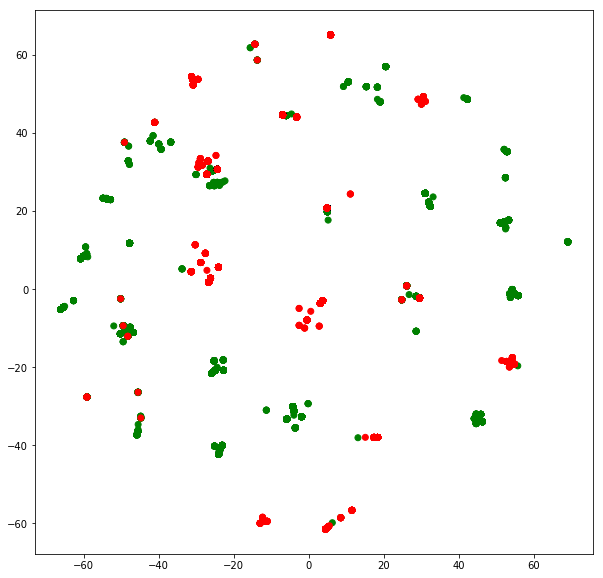

In [72]:
X,y = get_x_y(df__)
plot_tsne(X, y)

...:) better...

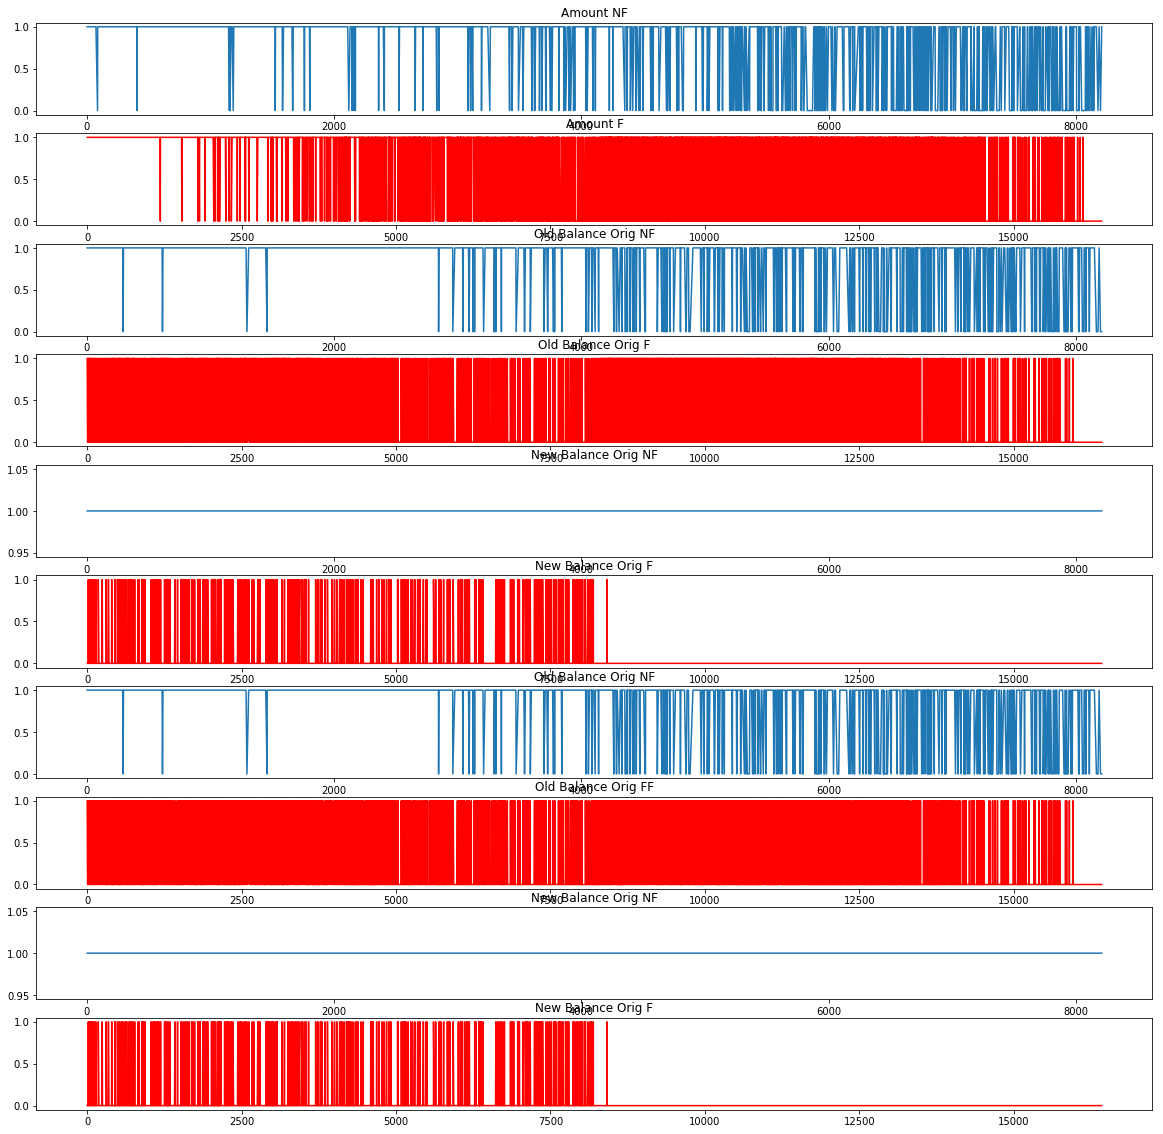

In [74]:
plot_money(df__)

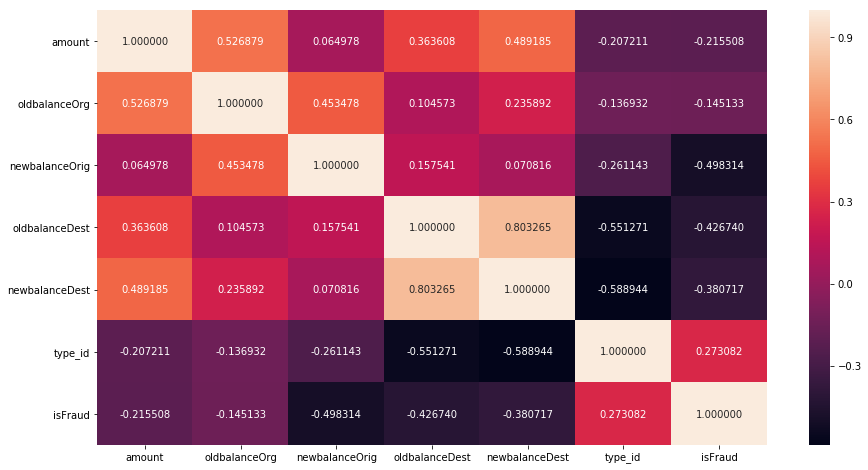

In [75]:
plot_correlation(df__)

## Basic tests

In [85]:
from sklearn.model_selection import train_test_split
X,y = get_x_y(df__)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

In [86]:
with open('fraud_train.csv', 'w') as csv:
    for x_,y_ in zip(X_train, y_train):
        line = "%s,%s" % (y_, ",".join( list(map(str, x_)) ) )
        csv.write( line + "\n" )
    csv.flush()
    csv.close()

with open('fraud_test.csv', 'w') as csv:
    for x_,y_ in zip(X_test, y_test):
        line = "%s,%s" % (y_, ",".join( list(map(str, x_)) ) )
        csv.write( line + "\n" )
    csv.flush()
    csv.close()

In [87]:
import sagemaker
import boto3

from sagemaker import get_execution_role
from sklearn.model_selection import train_test_split

role = get_execution_role()

prefix='fraud_detection'
# Retrieve the default bucket
sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()

INFO:sagemaker:Created S3 bucket: sagemaker-us-east-1-715445047862


In [88]:
# Upload the dataset to an S3 bucket
input_train = sagemaker_session.upload_data(path='fraud_train.csv', key_prefix='%s/data' % prefix)
input_test = sagemaker_session.upload_data(path='fraud_test.csv', key_prefix='%s/data' % prefix)

In [89]:
train_data = sagemaker.session.s3_input(s3_data=input_train,content_type="csv")
test_data = sagemaker.session.s3_input(s3_data=input_test,content_type="csv")

In [103]:
containers = {'us-west-2': '433757028032.dkr.ecr.us-west-2.amazonaws.com/xgboost:latest',
              'us-east-1': '811284229777.dkr.ecr.us-east-1.amazonaws.com/xgboost:latest',
              'us-east-2': '825641698319.dkr.ecr.us-east-2.amazonaws.com/xgboost:latest',
              'eu-west-1': '685385470294.dkr.ecr.eu-west-1.amazonaws.com/xgboost:latest'}

# Create the estimator
xgb = sagemaker.estimator.Estimator(containers[boto3.Session().region_name],
                                    role, 
                                    train_instance_count=1, 
                                    train_instance_type='ml.c5.xlarge',
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session=sagemaker_session)
# Set the hyperparameters
xgb.set_hyperparameters(eta=0.1,
                        max_depth=30,
                        gamma=4,
                        reg_lambda=10,
                        alpha=10,
                        min_child_weight=6,
                        silent=0,
                        objective='binary:logistic',
                        num_round=50)

In [ ]:
%%time
# takes around 3min 11s
xgb.fit({'train': train_data, 'validation': test_data, })

### Deploy the model and create an endpoint for it
The following action will:
 * get the assets from the job we just ran and then create an input in the Models Catalog
 * create a endpoint configuration (a metadata for our final endpoint)
 * create an enpoint, which is our model wrapped in a format of a WebService
 
After that we'll be able to call our deployed endpoint for doing predictions

In [105]:
%%time
xgb_predictor = xgb.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

INFO:sagemaker:Creating model with name: xgboost-2019-04-25-17-52-06-600
INFO:sagemaker:Creating endpoint with name xgboost-2019-04-25-17-33-06-046


-----------------------------------------------------------------------------------------------------!CPU times: user 513 ms, sys: 30.1 ms, total: 543 ms
Wall time: 8min 31s


In [106]:
endpoint_name = xgb_predictor.endpoint
model_name = boto3.client('sagemaker').describe_endpoint_config(
    EndpointConfigName=endpoint_name
)['ProductionVariants'][0]['ModelName']

## Now, let's do a basic test with the deployed endpoint
In this test, we'll use a helper object called predictor. This object is always returned from a **Deploy** call. The predictor is just for testing purposes and we'll not use it inside our real application.

In [107]:
from sagemaker.predictor import csv_serializer
from sklearn.metrics import f1_score

xgb_predictor.content_type = 'text/csv'
xgb_predictor.serializer = csv_serializer
xgb_predictor.deserializer = None

In [114]:
predictions_probs = [ float(xgb_predictor.predict(x).decode('utf-8')) for x in X_test ]
predictions_test = [ True if x >= 0.5 else False for x in predictions_probs ]
score = f1_score(y_test,predictions_test,labels=[True, False],average='micro')

print('F1 Score(micro): %.4f' % (score * 100.0))

F1 Score(micro): 92.0


## Plot ROC - AUC

In [117]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification

fpr, tpr, threshold = metrics.roc_curve(y_test, predictions_probs)
roc_auc = metrics.auc(fpr, tpr)

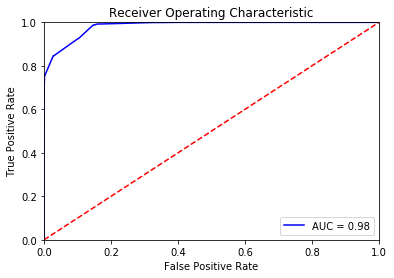

In [118]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Then, let's  test the API for our trained model
This is how your application will call the endpoint. Using boto3 for getting a sagemaker runtime client and then we'll call invoke_endpoint

In [119]:
sm = boto3.client('sagemaker-runtime')

In [130]:
from sagemaker.predictor import csv_serializer

resp = sm.invoke_endpoint(
    EndpointName=endpoint_name,
    ContentType='text/csv',
    Body=csv_serializer(X_test[5410])
)
prediction = float(resp['Body'].read().decode('utf-8'))
print('Predicted class: %.14f for [%s]' % (prediction, csv_serializer(X_test[0])) )

Predicted class: 0.77008146047600 for [9.999999977795539e-08,0.9999999000000003,0.9999999000000003,9.999999977795539e-08,9.999999977795539e-08,3.0]
